In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [3]:
import torch
from torch import nn
from torch.nn import  init
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F 
import os

### 读取图片文件

In [4]:
def getFileList(dir, FileList,ext=None):
    """
    获取文件夹及子文件夹中的文件列表
    dir: 文件夹跟目录
    ext:扩展名
    返回:文件路径列表
    """
    newDir=dir
    if os.path.isfile(dir):  # os.path.isfile(dir)判断某一对象(需提供绝对路径)是否为文件
        if ext is None:
            FileList.append(dir) # 将文件添加到FileList中
        else:
            if ext in dir[-3:]:
                FileList.append(dir)  # 去掉拓展名之后在添加到FileList中
    elif os.path.isdir(dir): # os.path.isdir()：判断某一对象(需提供绝对路径)是否为目录
        for s in os.listdir(dir):  # os.listdir()：返回一个列表，其中包含有指定路径下的目录和文件的名称
            """
            有时系统中会出现一个desktop.ini的隐藏文件会被读入
            """
            if s[-3:]=="jpg":
                newDir=os.path.join(dir,s)  # 拼接路径
                getFileList(newDir,FileList,ext)
        return FileList

In [5]:
# 检索文件
org_img_folder=r"D:\jupyter-notebook\8-15 实验3\dataset"  # bus car truck

total_imglist=[]
for folder in os.listdir(org_img_folder):
    new_org=os.path.join(org_img_folder,folder)
    imgList = getFileList(new_org,[])
    total_imglist.append(imgList)
    print('本次执行检索到 '+ folder +" "+str(len(imgList))+' 张图像\n')

本次执行检索到 bus 218 张图像

本次执行检索到 car 779 张图像

本次执行检索到 truck 360 张图像



In [6]:
bus_imglist=total_imglist[0]
car_imglist=total_imglist[1]
truck_imglist=total_imglist[2]

def tensor_list(imglist):
    count=0
    for array_img in imglist:
        img=Image.open(array_img)
        img=img.resize((64,64),Image.ANTIALIAS)
        img=np.array(img)
        img=np.expand_dims(img,0) # 从 100*100*3 变成 1*100*100*3
        # 归一化
        img=img/255 
        #1*H*W*C    1*C*H*W   0 1 2 3 ==> 0 3  1 2  X轴用0表示，Y轴用1表示；Z轴用2来表示；
        tensor_img=torch.tensor(np.transpose(img,(0,3,1,2)))
        if count==0:
            imglist=tensor_img
        else:
            imglist=torch.cat((imglist,tensor_img),0)
        count+=1
    return imglist

### 划分数据集

In [7]:
###训练集
bus_tensor=tensor_list(bus_imglist)
train_bus_tensor=bus_tensor[:int(bus_tensor.shape[0]*0.7)]


car_tensor=tensor_list(car_imglist)
train_car_tensor=car_tensor[:int(car_tensor.shape[0]*0.7)]

truck_tensor=tensor_list(truck_imglist)
train_truck_tensor=truck_tensor[:int(truck_tensor.shape[0]*0.7)]

print(train_bus_tensor.shape) # 152 3 100 100
print(train_car_tensor.shape) # 545 3 100 100
print(train_truck_tensor.shape) # 251

train_total_tensor=torch.cat((train_bus_tensor,train_car_tensor,train_truck_tensor),0)
print(train_total_tensor.shape)

torch.Size([152, 3, 64, 64])
torch.Size([545, 3, 64, 64])
torch.Size([251, 3, 64, 64])
torch.Size([948, 3, 64, 64])


In [8]:
# 测试集
test_bus_tensor=bus_tensor[int(bus_tensor.shape[0]*0.7):]
test_car_tensor=car_tensor[int(car_tensor.shape[0]*0.7):]
test_truck_tensor=truck_tensor[int(truck_tensor.shape[0]*0.7):]
test_total_tensor=torch.cat((test_bus_tensor,test_car_tensor,test_truck_tensor),0)
print(test_total_tensor.shape)

torch.Size([409, 3, 64, 64])


### 给类别分组 0 1 2

In [9]:
train_bus_labels=torch.zeros(train_bus_tensor.shape[0])  # bus 归为0类
train_car_labels=torch.ones(train_car_tensor.shape[0])   # car 归为1类
train_truck_labels=torch.ones(train_truck_tensor.shape[0])+1   # truck 归为2类

train_total_labels=torch.cat((train_bus_labels,train_car_labels,train_truck_labels),0)
print(train_total_labels.shape)


test_bus_labels=torch.zeros(test_bus_tensor.shape[0])  # bus 归为0类
test_car_labels=torch.ones(test_car_tensor.shape[0])   # car 归为1类
test_truck_labels=torch.ones(test_truck_tensor.shape[0])+1   # truck 归为2类

test_total_labels=torch.cat((test_bus_labels,test_car_labels,test_truck_labels),0)
print(test_total_labels.shape)

torch.Size([948])
torch.Size([409])


### 读取数据集

In [10]:
import torch.utils.data as Data

num_classes=3  # 3类
epochs=30

lr=0.001
batch_size=30
device=torch.device("cuda:0") # 使用device

# 将训练数据的特征和标签组合
train_dataset = Data.TensorDataset(train_total_tensor, train_total_labels)
# 把 dataset 放入 DataLoader
train_iter = Data.DataLoader(
    dataset=train_dataset, # torch TensorDataset format
    batch_size=batch_size, # mini batch size
    shuffle=True, # 是否打乱数据 (训练集一般需要进行打乱)
    num_workers=0, # 多线程来读数据，注意在Windows下需要设置为0
)

# 将训练数据的特征和标签组合
test_dataset = Data.TensorDataset(test_total_tensor, test_total_labels)
# 把 dataset 放入 DataLoader
test_iter = Data.DataLoader(
    dataset=test_dataset, # torch TensorDataset format
    batch_size=batch_size, # mini batch size
    shuffle=True, # 是否打乱数据 (训练集一般需要进行打乱)
    num_workers=0, # 多线程来读数据，注意在Windows下需要设置为0
)

### pytorch 实现卷积

In [11]:

#     输入： 
#     (30, 3 64 64)
#     ## 第一层
#     conv： (H-K+2*P)/S + 1
#     (64-11+2*2)/4+1==>15.25==>15
#     (30,96, 15 15)
#     pool: (15-3+0)/2 + 1= 7   第一层 (30,96,7,7)

#     ## 第二层
#     conv: (7-5+2)/1+1=5
#     pool:(5-3+0)/2+1=2   第二层(30,256,2,2)


#     ## 第三层
#     conv: (2-3+2)/1+1=2   第三层(30,384,2,2)

#     ## 第四层
#     conv: (2-3+2)/1+1=2   第四层(30,384,2,2)


#     conv 的输出 为 fc 的输入  384*2*2


   # ceil_mode指明，当剩余的像素不足滤波器大小，是否仍对这些像素进行运算。

In [24]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet,self).__init__()
        ### 定义卷积层
        self.conv1=nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=96,kernel_size=11,stride=4,padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3,stride=2,ceil_mode=True)
        )
        self.conv2=nn.Sequential(
            nn.Conv2d(in_channels=96,out_channels=256,kernel_size=5,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3,stride=2,ceil_mode=True)
        )
        self.conv3=nn.Sequential(
            nn.Conv2d(in_channels=256,out_channels=384,kernel_size=3,stride=1,padding=1),
            nn.ReLU()
        )
        self.conv4=nn.Sequential(
            nn.Conv2d(in_channels=384,out_channels=384,kernel_size=3,stride=1,padding=1),
            nn.ReLU()
        )
        ### 定义全连接层
        self.fc=nn.Sequential(
            ## fc1
            nn.Dropout(0.5),
            nn.Linear(in_features=384*2*2,out_features=120),
            nn.ReLU(),
            nn.Dropout(0.5),
            ## fc2
            nn.Linear(in_features=120,out_features=84),
            nn.ReLU(),
            ## fc3
            nn.Linear(in_features=84,out_features=num_classes)  # 最后输出3类
        )
    
    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x) 
        x = x.view(-1,384*2*2)
        x = self.fc(x)
        return x

### 初始化+损失函数+优化器

In [13]:
## 模型定义
net=AlexNet().to(device)
## loss函数
criterion=nn.CrossEntropyLoss()
## 使用Adam优化器
optimizer=torch.optim.Adam(net.parameters(),lr=lr)

### 测试训练函数

In [14]:
def train_epoch(net,data_loader,device):
    net.train()  ## 当前模式为训练模式
    train_batch_num=len(data_loader)  # 记录有多少个batch
    total_loss=0 # 记录loss
    correct=0    # 记录共有多个个样本被正确分类
    sample_num=0  # 记录样本总数
    
    ### 遍历每一个batch进行训练
    for batch_idx,(data,target)  in enumerate(data_loader):
        # 将图片放入指定的device中
        data=data.to(device).float()
        # 将图片标签放入指定的device中
        target=target.to(device).long()
        #将当前梯度清0
        optimizer.zero_grad()
        # 使用模型计算结果
        output=net(data)
        # 计算损失
        loss=criterion(output,target.squeeze())
        # 进行反向传播
        loss.backward()
        optimizer.step()
        #累加Loss
        total_loss+=loss.item()
        # 找出每个样本最大的idx，即代表类别
        prediction=torch.argmax(output,1)
        # 统计正确的类别数量
        correct+=(prediction==target).sum().item()
        # 累加当前样本总数
        sample_num+=len(prediction)
    # 计算平均的loss与准确率
    loss=total_loss/train_batch_num
    acc=correct/sample_num
    return loss,acc

### 测试函数

In [15]:
def test_epoch(net,data_loader,device):
    net.eval()  ## 当前模式为训练模式
    test_batch_num=len(data_loader)  # 记录有多少个batch
    total_loss=0 # 记录loss
    correct=0    # 记录共有多个个样本被正确分类
    sample_num=0  # 记录样本总数
    
    
    with torch.no_grad():
        ### 遍历每一个batch进行训练
        for batch_idx,(data,target)  in enumerate(data_loader):
            # 将图片放入指定的device中
            data=data.to(device).float()
            # 将图片标签放入指定的device中
            target=target.to(device).long()
            
            output=net(data)
            # 计算损失
            loss=criterion(output,target)
        
            #累加Loss
            total_loss+=loss.item()
            # 找出每个样本最大的idx，即代表类别
            prediction=torch.argmax(output,1)
            # 统计正确的类别数量
            correct+=(prediction==target).sum().item()
            # 累加当前样本总数
            sample_num+=len(prediction)
    # 计算平均的loss与准确率
    loss=total_loss/test_batch_num
    acc=correct/sample_num
    return loss,acc

### 开始训练

In [16]:
train_loss_list=[]
train_acc_list=[]
test_loss_list=[]
test_acc_list=[]

# 进行训练
for epoch in range(epochs):
    # 在训练集上训练
    train_loss,train_acc=train_epoch(net,train_iter,device=device)
    # 在测试集上验证
    test_loss,test_acc=test_epoch(net,test_iter,device=device)
    
    ## 保存各个指标
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
   
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)
    
    print(f"epoch:{epoch}  train_loss:{train_loss:.4f}  "
          f"train_acc:{train_acc}  "
          f"test_loss:{test_loss:.4f}  test_acc:{test_acc}")

D:\download\Anaconda\envs\pytorch\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch:0  train_loss:0.8996  train_acc:0.580168776371308  test_loss:1.0804  test_acc:0.5721271393643031
epoch:1  train_loss:0.5746  train_acc:0.7637130801687764  test_loss:1.1908  test_acc:0.3056234718826406
epoch:2  train_loss:0.4293  train_acc:0.7932489451476793  test_loss:1.7761  test_acc:0.5256723716381418
epoch:3  train_loss:0.3293  train_acc:0.8786919831223629  test_loss:2.5183  test_acc:0.42053789731051344
epoch:4  train_loss:0.2232  train_acc:0.9187763713080169  test_loss:1.3119  test_acc:0.6112469437652812
epoch:5  train_loss:0.1934  train_acc:0.9282700421940928  test_loss:2.5039  test_acc:0.4963325183374083
epoch:6  train_loss:0.2123  train_acc:0.9345991561181435  test_loss:2.0975  test_acc:0.36674816625916873
epoch:7  train_loss:0.2143  train_acc:0.930379746835443  test_loss:2.5393  test_acc:0.49144254278728605
epoch:8  train_loss:0.1251  train_acc:0.95042194092827  test_loss:2.7450  test_acc:0.5501222493887531
epoch:9  train_loss:0.1596  train_acc:0.9525316455696202  test_lo

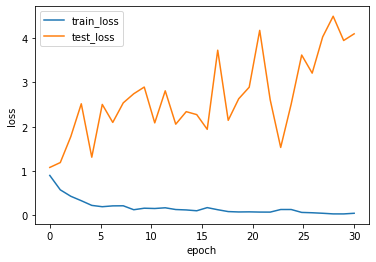

In [20]:
x = np.linspace(0,len(train_loss_list),len(train_loss_list))
plt.plot(x,train_loss_list,label="train_loss",linewidth=1.5)
plt.plot(x,test_loss_list,label="test_loss",linewidth=1.5)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.savefig("AlexNet_loss.jpg")
plt.show()

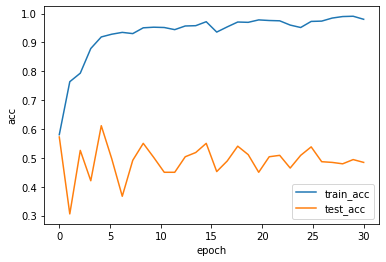

In [21]:
x = np.linspace(0,len(train_acc_list),len(train_acc_list))
plt.plot(x,train_acc_list,label="train_acc",linewidth=1.5)
plt.plot(x,test_acc_list,label="test_acc",linewidth=1.5)
plt.xlabel("epoch")
plt.ylabel("acc")
plt.legend()
plt.savefig("AlexNet_acc.jpg")
plt.show()